<a href="https://colab.research.google.com/github/piyush-bhandari-commits/ml-projects/blob/master/Identification_of_Crisis_Related_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nltk
import matplotlib.pyplot as plt 
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, Dropout, Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing Data and Cleaning 

In [ ]:
def read_csv(path):
    data = pd.read_csv(path)
    return data

In [ ]:
# Cleaning the training data to remove noise and unwanted words
def clean_text(text):
    no_user_tweet = re.sub('@[\w]*', '', text.lower())
    no_url_tweet = re.sub(r"http\S+", "", no_user_tweet)
    no_punct_text = re.sub("[^a-zA-Z#]", " ", no_url_tweet)
    no_small_text = " ".join([word for word in no_punct_text.split() if len(word)>2])
    no_stop_text = " ".join([word for word in no_small_text.split() if word not in stopwords])
    tokens = re.split('\W+', no_stop_text)
    return tokens

(10008, 3)
No. of tweets on-topic: 6138
No. of tweets off-topic: 3870


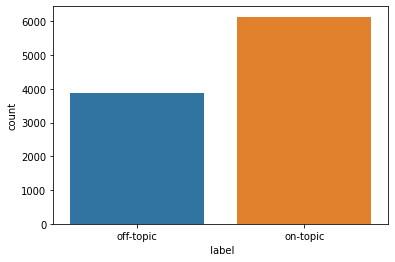

In [ ]:
data = dict()
data['sandy_hurricane'] = read_csv('/content/drive/My Drive/Colab Notebooks/ECE 657/project/CrisisLexT6/2012_Sandy_Hurricane/2012_Sandy_Hurricane-ontopic_offtopic.csv')
data['sandy_hurricane'].head()
print (data['sandy_hurricane'].shape)
sns.countplot(data['sandy_hurricane'][' label'])
print ('No. of tweets on-topic: {}'.format(sum(data['sandy_hurricane'][' label']=='on-topic')))
print ('No. of tweets off-topic: {}'.format(sum(data['sandy_hurricane'][' label']=='off-topic')))

No. of tweets on-topic: 5648
No. of tweets off-topic: 4364


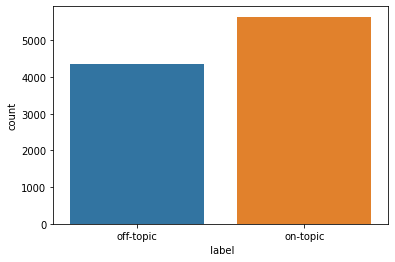

In [ ]:
data['boston_bombings'] = read_csv('/content/drive/My Drive/Colab Notebooks/ECE 657/project/CrisisLexT6/2013_Boston_Bombings/2013_Boston_Bombings-ontopic_offtopic.csv')
data['boston_bombings'].head()
sns.countplot(data['boston_bombings'][' label'])
print ('No. of tweets on-topic: {}'.format(sum(data['boston_bombings'][' label']=='on-topic')))
print ('No. of tweets off-topic: {}'.format(sum(data['boston_bombings'][' label']=='off-topic')))

No. of tweets on-topic: 5414
No. of tweets off-topic: 4619


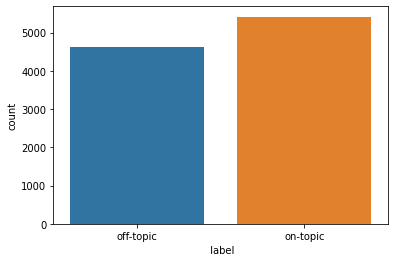

In [ ]:
data['queen_floods'] = read_csv('/content/drive/My Drive/Colab Notebooks/ECE 657/project/CrisisLexT6/2013_Queensland_Floods/2013_Queensland_Floods-ontopic_offtopic.csv')
data['queen_floods'].head()
sns.countplot(data['queen_floods'][' label'])
print ('No. of tweets on-topic: {}'.format(sum(data['queen_floods'][' label']=='on-topic')))
print ('No. of tweets off-topic: {}'.format(sum(data['queen_floods'][' label']=='off-topic')))

No. of tweets on-topic: 5189
No. of tweets off-topic: 4842


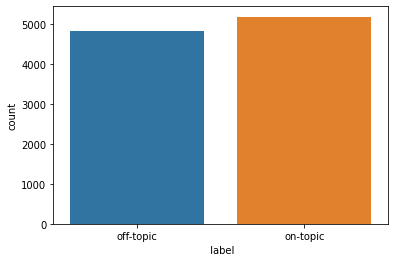

In [ ]:
data['alberta_floods'] = read_csv('/content/drive/My Drive/Colab Notebooks/ECE 657/project/CrisisLexT6/2013_Alberta_Floods/2013_Alberta_Floods-ontopic_offtopic.csv')
data['alberta_floods'].head()
sns.countplot(data['alberta_floods'][' label'])
print ('No. of tweets on-topic: {}'.format(sum(data['alberta_floods'][' label']=='on-topic')))
print ('No. of tweets off-topic: {}'.format(sum(data['alberta_floods'][' label']=='off-topic')))

No. of tweets on-topic: 4827
No. of tweets off-topic: 5165


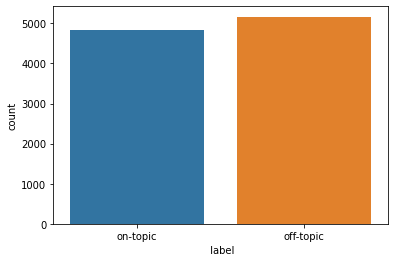

In [ ]:
data['oklahoma_tornado'] = read_csv('/content/drive/My Drive/Colab Notebooks/ECE 657/project/CrisisLexT6/2013_Oklahoma_Tornado/2013_Oklahoma_Tornado-ontopic_offtopic.csv')
data['oklahoma_tornado'].head()
sns.countplot(data['oklahoma_tornado'][' label'])
print ('No. of tweets on-topic: {}'.format(sum(data['oklahoma_tornado'][' label']=='on-topic')))
print ('No. of tweets off-topic: {}'.format(sum(data['oklahoma_tornado'][' label']=='off-topic')))

No. of tweets on-topic: 5246
No. of tweets off-topic: 4760


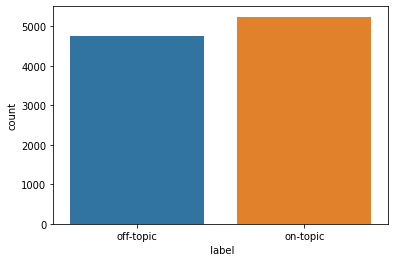

In [ ]:
data['texas_explosion'] = read_csv('/content/drive/My Drive/Colab Notebooks/ECE 657/project/CrisisLexT6/2013_West_Texas_Explosion/2013_West_Texas_Explosion-ontopic_offtopic.csv')
data['texas_explosion'].head()
sns.countplot(data['texas_explosion'][' label'])
print ('No. of tweets on-topic: {}'.format(sum(data['texas_explosion'][' label']=='on-topic')))
print ('No. of tweets off-topic: {}'.format(sum(data['texas_explosion'][' label']=='off-topic')))

In [ ]:
combine_data = data['queen_floods'].append([data['sandy_hurricane'], data['boston_bombings'], data['oklahoma_tornado'])
dataset = shuffle(combine_data.drop(['tweet id'], axis=1))
dict_map = {'off-topic' : 0, 'on-topic': 1}
dataset[' label'] = dataset[' label'].map(dict_map, na_action='ignore')
dataset.head()

,tweet,label
1970,#honestyhour I don't like you.,0
2525,RIP Jim Kelly Black Belt Jones! Oiiiiiiii ! ht...,0
7296,CAUGHT ON CAMERA: Fertilizer plant explosion n...,1
4485,"While one death or injury is too many, glad to...",1
6407,Roam wants to let the people of Oklahoma & oth...,1


Text(0, 0.5, 'Number of Samples')

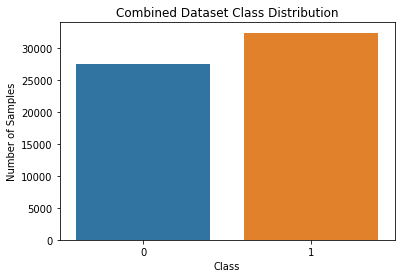

In [ ]:
sns.countplot(dataset[' label'])
plt.title('Combined Dataset Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')

In [ ]:
# Splitting the data into train and test set
x = dataset[' tweet'].values
y = dataset[' label'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

train_data = pd.DataFrame(data=x_train, columns=['tweet'])
train_data['label'] = y_train

test_data = pd.DataFrame(data=x_test, columns=['tweet'])
test_data['label'] = y_test

In [ ]:
train_data.shape
test_data.shape

(12017, 2)

In [ ]:
# Cleaning the train set by using clean_text()
train_data['clean_tokens'] = train_data['tweet'].apply(lambda x: clean_text(x))
train_data['clean_sentence'] = train_data['clean_tokens'].apply(lambda x: " ".join(x))
train_data.head(5)

,tweet,label,clean_tokens,clean_sentence
0,RT @iTweetFacts: First the Boston marathon bom...,1,"[first, boston, marathon, bombing, pray, waco,...",first boston marathon bombing pray waco westtx
1,RT @HealthyNewDawn: WTG!! Blackfoot truckstop ...,1,"[wtg, blackfoot, truckstop, feeding, first, re...",wtg blackfoot truckstop feeding first responde...
2,@Girlgiveme_that: Okay I really need to stay o...,0,"[okay, really, need, stay, vinei, keep, refres...",okay really need stay vinei keep refreshing ho...
3,To stay in Waco or go home for the night hmmm,0,"[stay, waco, home, night, hmmm]",stay waco home night hmmm
4,Sound check all done! See ya's soon. #CanadaPr...,0,"[sound, check, done, see, soon, canadaproud, s...",sound check done see soon canadaproud showtime


In [ ]:
# Converting train and test data into sequences for keras model - Word level embeddings
max_words = 20000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data['clean_tokens'])

word_index = tokenizer.word_index
x_train_seq = tokenizer.texts_to_sequences(train_data['clean_tokens'])
x_train_pad = pad_sequences(x_train_seq, maxlen=200)
y_train_cat = to_categorical(train_data['label'])

x_test_seq = tokenizer.texts_to_sequences(test_data['tweet'])
x_test_pad = pad_sequences(x_test_seq, maxlen=200)
y_test_cat = to_categorical(test_data['label'])

# Training Models with Word2Vec Embeddings

In [ ]:
w2v_model = Word2Vec(train_data['clean_tokens'], size=350, workers=3, window=3, sg=1, seed=42)

In [ ]:
w2v_model.wv.most_similar(positive=['bombings'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('attack', 0.9552180171012878),
 ('attacks', 0.9223988056182861),
 ('bombing', 0.9152242541313171),
 ('blasts', 0.9152122735977173),
 ('saddened', 0.9063096642494202),
 ('donatetoboston', 0.9061954617500305),
 ('brothers', 0.9042543172836304),
 ('runner', 0.901660680770874),
 ('terror', 0.9014378190040588),
 ('investigation', 0.8967398405075073)]

In [ ]:
cnn_w2v_model = Sequential()
cnn_w2v_model.add(Embedding(len(word_index) + 1, 200,
                    input_length=x_train_pad.shape[1],
                    trainable=True))

cnn_w2v_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_w2v_model.add(Dropout(0.3))
cnn_w2v_model.add(MaxPooling1D(pool_size=2))
cnn_w2v_model.add(Dropout(0.2))
cnn_w2v_model.add(Flatten())
cnn_w2v_model.add(Dense(250, activation='relu'))
cnn_w2v_model.add(Dropout(0.2))
cnn_w2v_model.add(Dense(2, activation='softmax'))
cnn_w2v_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_w2v_model.fit(x_train_pad, y_train_cat, batch_size=128, epochs=3, validation_split=0.20)

Epoch 1/3
301/301 [==============================] - 20s 67ms/step - loss: 0.2291 - accuracy: 0.9102 - val_loss: 0.1584 - val_accuracy: 0.9474
Epoch 2/3
301/301 [==============================] - 20s 67ms/step - loss: 0.1219 - accuracy: 0.9594 - val_loss: 0.1658 - val_accuracy: 0.9434
Epoch 3/3
301/301 [==============================] - 20s 66ms/step - loss: 0.0871 - accuracy: 0.9714 - val_loss: 0.1771 - val_accuracy: 0.9366


In [ ]:
cnn_w2v_model.save('/content/drive/My Drive/Colab Notebooks/ECE 657/project/models/cnn_w2v_model.h5')

In [ ]:
lstm_w2v_model = Sequential()
lstm_w2v_model.add(Embedding(len(word_index) + 1, 200,
                    input_length=x_train_pad.shape[1],
                    trainable=True))
lstm_w2v_model.add(LSTM(units=50, return_sequences=False))
lstm_w2v_model.add(Dropout(0.2))
lstm_w2v_model.add(Dense(units = 2, activation='softmax'))
lstm_w2v_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_w2v_model.fit(x_train_pad, y_train_cat, batch_size=128, epochs=3, validation_split=0.20)

Epoch 1/3
301/301 [==============================] - 24s 81ms/step - loss: 0.2209 - accuracy: 0.9170 - val_loss: 0.1508 - val_accuracy: 0.9503
Epoch 2/3
301/301 [==============================] - 24s 79ms/step - loss: 0.1185 - accuracy: 0.9614 - val_loss: 0.1634 - val_accuracy: 0.9435
Epoch 3/3
301/301 [==============================] - 24s 79ms/step - loss: 0.0928 - accuracy: 0.9697 - val_loss: 0.1961 - val_accuracy: 0.9320


In [ ]:
lstm_w2v_model.save('/content/drive/My Drive/Colab Notebooks/ECE 657/project/models/lstm_w2v_model.h5')

In [ ]:
bilstm_w2v_model = Sequential()
bilstm_w2v_model.add(Embedding(len(word_index) + 1, 200,
                    input_length=x_train_pad.shape[1],
                    trainable=True))
bilstm_w2v_model.add( Bidirectional( LSTM(196)))
# lstm_w2v_model.add(LSTM(units=50, return_sequences=False))
# lstm_w2v_model.add(Dropout(0.2))
bilstm_w2v_model.add(Dense(units = 2, activation='softmax'))
bilstm_w2v_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_w2v_model.fit(x_train_pad, y_train_cat, batch_size=128, epochs=3, validation_split=0.20)

Epoch 1/3
301/301 [==============================] - 36s 119ms/step - loss: 0.2255 - accuracy: 0.9134 - val_loss: 0.1540 - val_accuracy: 0.9489
Epoch 2/3
301/301 [==============================] - 34s 114ms/step - loss: 0.1172 - accuracy: 0.9607 - val_loss: 0.1678 - val_accuracy: 0.9426
Epoch 3/3
301/301 [==============================] - 34s 114ms/step - loss: 0.0916 - accuracy: 0.9699 - val_loss: 0.2017 - val_accuracy: 0.9332


In [ ]:
bilstm_w2v_model.save('/content/drive/My Drive/Colab Notebooks/ECE 657/project/models/bilstm_w2v_model.h5')

# Training Models with GloVe Embeddings

In [ ]:
f = open('/content/drive/My Drive/Colab Notebooks/glove.twitter.27B.50d.txt')
embedd_index = {}
for line in f:
    val = line.split()
    word = val[0]
    coff = np.asarray(val[1:],dtype = 'float')
    embedd_index[word] = coff

f.close()
print('Found %s word vectors.' % len(embedd_index))

Found 1193514 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 50))

tokens = []
labels = []

for word,i in word_index.items():
    temp = embedd_index.get(word)
    if temp is not None:
        embedding_matrix[i] = temp
        tokens.append(embedding_matrix[i])
        labels.append(word)

In [ ]:
cnn_glove_model = Sequential()
cnn_glove_model.add(Embedding(len(word_index) + 1, 50,
                    input_length=x_train_pad.shape[1],
                    trainable=False, weights=[embedding_matrix]))
cnn_glove_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_glove_model.add(Dropout(0.3))
cnn_glove_model.add(MaxPooling1D(pool_size=2))
cnn_glove_model.add(Dropout(0.2))
cnn_glove_model.add(Flatten())
cnn_glove_model.add(Dense(250, activation='relu'))
cnn_glove_model.add(Dropout(0.2))
cnn_glove_model.add(Dense(2, activation='softmax'))
# model.add(Dropout(0.1))
cnn_glove_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_glove_model.fit(x_train_pad, y_train_cat, batch_size=128, epochs=3, validation_split=0.20)

Epoch 1/3
301/301 [==============================] - 2s 6ms/step - loss: 0.2784 - accuracy: 0.8865 - val_loss: 0.2116 - val_accuracy: 0.9219
Epoch 2/3
301/301 [==============================] - 2s 5ms/step - loss: 0.2214 - accuracy: 0.9183 - val_loss: 0.1968 - val_accuracy: 0.9286
Epoch 3/3
301/301 [==============================] - 2s 5ms/step - loss: 0.2098 - accuracy: 0.9234 - val_loss: 0.1938 - val_accuracy: 0.9298


In [ ]:
cnn_glove_model.save('/content/drive/My Drive/Colab Notebooks/ECE 657/project/models/cnn_glove_model.h5')

In [ ]:
lstm_glove_model = Sequential()
lstm_glove_model.add(Embedding(len(word_index) + 1, 50,
                    input_length=x_train_pad.shape[1],
                    trainable=False, weights=[embedding_matrix]))
lstm_glove_model.add(LSTM(units=50, return_sequences=False))
lstm_glove_model.add(Dropout(0.2))
lstm_glove_model.add(Dense(units = 2, activation='softmax'))
lstm_glove_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_glove_model.fit(x_train_pad, y_train_cat, batch_size= 128, epochs=3, validation_split=0.20)

Epoch 1/3
301/301 [==============================] - 4s 13ms/step - loss: 0.2609 - accuracy: 0.8992 - val_loss: 0.2015 - val_accuracy: 0.9245
Epoch 2/3
301/301 [==============================] - 4s 12ms/step - loss: 0.1991 - accuracy: 0.9295 - val_loss: 0.1902 - val_accuracy: 0.9345
Epoch 3/3
301/301 [==============================] - 4s 12ms/step - loss: 0.1856 - accuracy: 0.9345 - val_loss: 0.1725 - val_accuracy: 0.9395


In [ ]:
lstm_glove_model.save('/content/drive/My Drive/Colab Notebooks/ECE 657/project/models/lstm_glove_model.h5')

In [ ]:
bilstm_glove_model = Sequential()
bilstm_glove_model.add(Embedding(len(word_index) + 1, 50,
                    input_length=x_train_pad.shape[1],
                    trainable=False, weights=[embedding_matrix]))
bilstm_glove_model.add( Bidirectional( LSTM(196)))
bilstm_glove_model.add(Dense(units = 2, activation='softmax'))
bilstm_glove_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_glove_model.fit(x_train_pad, y_train_cat, batch_size=128, epochs=3, validation_split=0.20)

Epoch 1/3
301/301 [==============================] - 16s 52ms/step - loss: 0.2374 - accuracy: 0.9102 - val_loss: 0.1914 - val_accuracy: 0.9302
Epoch 2/3
301/301 [==============================] - 15s 49ms/step - loss: 0.1886 - accuracy: 0.9329 - val_loss: 0.1786 - val_accuracy: 0.9362
Epoch 3/3
301/301 [==============================] - 15s 49ms/step - loss: 0.1750 - accuracy: 0.9372 - val_loss: 0.1671 - val_accuracy: 0.9409


In [ ]:
bilstm_glove_model.save('/content/drive/My Drive/Colab Notebooks/ECE 657/project/models/bilstm_glove_model.h5')

# Training model with Character Embeddings

In [ ]:
max_words = 20000
char_tokenizer = Tokenizer(char_level=True, oov_token='UNK')
char_tokenizer.fit_on_texts(train_data['clean_sentence'])

# # Constructing a new vocabulary
# alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
# char_dict = {}
# for i, char in enumerate(alphabet):
#     char_dict[char] = i + 1


# char_tokenizer.word_index = char_dict.copy()

# char_tokenizer.word_index[char_tokenizer.oov_token] = max(char_dict.values()) + 1

x_train_seq = char_tokenizer.texts_to_sequences(train_data['clean_sentence'])
char_x_train_pad = pad_sequences(x_train_seq, maxlen=200)
char_y_train_cat = to_categorical(train_data['label'])

x_test_seq = char_tokenizer.texts_to_sequences(test_data['tweet'])
char_x_test_pad = pad_sequences(x_test_seq, maxlen=200)
char_y_test_cat = to_categorical(test_data['label'])

vocab_size = len(char_tokenizer.word_index)
# char_tokenizer.word_index

In [ ]:
char_tokenizer.word_index

{' ': 2,
 'UNK': 1,
 'a': 4,
 'b': 21,
 'c': 13,
 'd': 12,
 'e': 3,
 'f': 20,
 'g': 15,
 'h': 14,
 'i': 10,
 'j': 28,
 'k': 23,
 'l': 11,
 'm': 18,
 'n': 8,
 'o': 5,
 'p': 16,
 'q': 26,
 'r': 9,
 's': 6,
 't': 7,
 'u': 17,
 'v': 24,
 'w': 22,
 'x': 25,
 'y': 19,
 'z': 27}

In [ ]:
# embedding_weights = []
# embedding_weights.append(np.zeros(vocab_size))

# for char, i in char_tokenizer.word_index.items():
#     one_hot = np.zeros(vocab_size)
#     one_hot[i-1] = 1
#     embedding_weights.append(one_hot)

# embedding_weights = np.array(embedding_weights)

In [ ]:
cnn_char_model = Sequential()
cnn_char_model.add(Embedding(len(word_index) + 1, 200,
                    input_length=x_train_pad.shape[1],
                    trainable=True))
cnn_char_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_char_model.add(Dropout(0.3))
cnn_char_model.add(MaxPooling1D(pool_size=2))
cnn_char_model.add(Dropout(0.2))
cnn_char_model.add(Flatten())
cnn_char_model.add(Dense(250, activation='relu'))
cnn_char_model.add(Dropout(0.2))
cnn_char_model.add(Dense(2, activation='softmax'))
# model.add(Dropout(0.1))
cnn_char_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_char_model.fit(char_x_train_pad, char_y_train_cat, batch_size=128, epochs=3, validation_split=0.20)

Epoch 1/3
301/301 [==============================] - 20s 67ms/step - loss: 0.3661 - accuracy: 0.8414 - val_loss: 0.2472 - val_accuracy: 0.9132
Epoch 2/3
301/301 [==============================] - 20s 67ms/step - loss: 0.2576 - accuracy: 0.9054 - val_loss: 0.2175 - val_accuracy: 0.9273
Epoch 3/3
301/301 [==============================] - 20s 66ms/step - loss: 0.2325 - accuracy: 0.9159 - val_loss: 0.2109 - val_accuracy: 0.9306


In [ ]:
cnn_char_model.save('/content/drive/My Drive/Colab Notebooks/ECE 657/project/models/cnn_char_model.h5')

In [ ]:
lstm_char_model = Sequential()
lstm_char_model.add(Embedding(len(word_index) + 1, 200,
                    input_length=x_train_pad.shape[1],
                    trainable=True))
lstm_char_model.add(LSTM(units=50, return_sequences=False))
lstm_char_model.add(Dropout(0.2))
lstm_char_model.add(Dense(units = 2, activation='softmax'))
lstm_char_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_char_model.fit(char_x_train_pad, char_y_train_cat, batch_size= 128, epochs=3, validation_split=0.20)

Epoch 1/3
301/301 [==============================] - 25s 83ms/step - loss: 0.4619 - accuracy: 0.7875 - val_loss: 0.3932 - val_accuracy: 0.8410
Epoch 2/3
301/301 [==============================] - 24s 80ms/step - loss: 0.3155 - accuracy: 0.8869 - val_loss: 0.2658 - val_accuracy: 0.9107
Epoch 3/3
301/301 [==============================] - 24s 80ms/step - loss: 0.2555 - accuracy: 0.9165 - val_loss: 0.2458 - val_accuracy: 0.9183


In [ ]:
lstm_char_model.save('/content/drive/My Drive/Colab Notebooks/ECE 657/project/models/lstm_char_model.h5')

In [ ]:
bilstm_char_model = Sequential()
bilstm_char_model.add(Embedding(len(word_index) + 1, 200,
                    input_length=x_train_pad.shape[1],
                    trainable=True))
bilstm_char_model.add( Bidirectional( LSTM(196)))
bilstm_char_model.add(Dense(units = 2, activation='softmax'))
bilstm_char_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bilstm_char_model.fit(char_x_train_pad, char_y_train_cat, batch_size=128, epochs=3, validation_split=0.20)

Epoch 1/3
301/301 [==============================] - 35s 115ms/step - loss: 0.4573 - accuracy: 0.7904 - val_loss: 0.3522 - val_accuracy: 0.8648
Epoch 2/3
301/301 [==============================] - 33s 110ms/step - loss: 0.2883 - accuracy: 0.9005 - val_loss: 0.2529 - val_accuracy: 0.9156
Epoch 3/3
301/301 [==============================] - 34s 111ms/step - loss: 0.2448 - accuracy: 0.9207 - val_loss: 0.2252 - val_accuracy: 0.9287


In [ ]:
bilstm_char_model.save('/content/drive/My Drive/Colab Notebooks/ECE 657/project/models/bilstm_char_model.h5')

# Evaluating Model Performance

In [ ]:
w2v_models = {'cnn' : load_model('/content/drive/My Drive/Colab Notebooks/ECE 657/project/models/cnn_w2v_model.h5'),
              'lstm': load_model('/content/drive/My Drive/Colab Notebooks/ECE 657/project/models/lstm_w2v_model.h5'),
              'bilstm': load_model('/content/drive/My Drive/Colab Notebooks/ECE 657/project/models/bilstm_w2v_model.h5')
              }

In [ ]:
glove_models = {'cnn' : load_model('/content/drive/My Drive/Colab Notebooks/ECE 657/project/models/cnn_glove_model.h5'),
              'lstm': load_model('/content/drive/My Drive/Colab Notebooks/ECE 657/project/models/lstm_glove_model.h5'),
              'bilstm': load_model('/content/drive/My Drive/Colab Notebooks/ECE 657/project/models/bilstm_glove_model.h5')
              }

In [ ]:
char_models = {'cnn' : load_model('/content/drive/My Drive/Colab Notebooks/ECE 657/project/models/cnn_char_model.h5'),
              'lstm': load_model('/content/drive/My Drive/Colab Notebooks/ECE 657/project/models/lstm_char_model.h5'),
              'bilstm': load_model('/content/drive/My Drive/Colab Notebooks/ECE 657/project/models/bilstm_char_model.h5')
              }

In [ ]:
def get_metrics(model, x_test):
    y_predict = model.predict(x_test)
    y_predict_final = np.argmax(y_predict, axis=1)
    precision, recall, f1, support = precision_recall_fscore_support(test_data['label'].values, y_predict_final, average='weighted')
    acc = accuracy_score(test_data['label'].values, y_predict_final)
    result = [acc, precision, recall, f1]
    return result

In [ ]:
results = {}
results['w2v_cnn'] = get_metrics(w2v_models['cnn'], x_test_pad)
results['w2v_lstm'] = get_metrics(w2v_models['lstm'], x_test_pad)
results['w2v_bilstm'] = get_metrics(w2v_models['bilstm'], x_test_pad)

results['glove_cnn'] = get_metrics(glove_models['cnn'], x_test_pad)
results['glove_lstm'] = get_metrics(glove_models['lstm'], x_test_pad)
results['glove_bilstm'] = get_metrics(glove_models['bilstm'], x_test_pad)

results['char_cnn'] = get_metrics(char_models['cnn'], char_x_test_pad)
results['char_lstm'] = get_metrics(char_models['lstm'], char_x_test_pad)
results['char_bilstm'] = get_metrics(char_models['bilstm'], char_x_test_pad)

NameError: ignored

In [ ]:
df_results = pd.DataFrame(results).transpose()
df_results.columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
df_results

,Accuracy,Precision,Recall,F1-Score
w2v_cnn,0.918615,0.918790,0.918615,0.918649
w2v_lstm,0.918948,0.919275,0.918948,0.918839
w2v_bilstm,0.918615,0.918632,0.918615,0.918622
glove_cnn,0.917617,0.917615,0.917617,0.917585
glove_lstm,0.914704,0.917763,0.914704,0.914284
glove_bilstm,0.916368,0.919095,0.916368,0.915989
char_cnn,0.863277,0.876708,0.863277,0.861065
char_lstm,0.906133,0.906778,0.906133,0.905944
char_bilstm,0.923691,0.923792,0.923691,0.923631


In [ ]:
import plotly.graph_objects as go

def get_plot(result_data):
    models=list(result_data.index)

    accuracy = [round(item, 4) for item in result_data['Accuracy'].values]
    precision = [round(item, 4) for item in result_data['Precision'].values]
    recall = [round(item, 4) for item in result_data['Recall'].values]
    f1 = [round(item, 4) for item in result_data['F1-Score'].values]

    fig = go.Figure(data=[
        go.Bar(name='Accuracy', x=models, y=accuracy, text=accuracy, textposition='auto'),
        go.Bar(name='Precision', x=models, y=precision, text=precision, textposition='auto'),
        go.Bar(name='Recall', x=models, y=recall, text=recall, textposition='auto'),
        go.Bar(name='F1-Score', x=models, y=f1, text=f1, textposition='auto')
    ])

    fig.update_layout(barmode='group', width=500, height=500,
    xaxis_title="Model with Embedding Type",
    yaxis_title="Metric Value", title={
        'text': "Performance of Bi-LSTM Model",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
        })
    fig.show()

In [ ]:
get_plot(df_results)

In [ ]:
cnn_result = df_results.loc[["w2v_cnn", "glove_cnn", "char_cnn"]]
get_plot(cnn_result)

In [ ]:
lstm_result = df_results.loc[["w2v_lstm", "glove_lstm", "char_lstm"]]
get_plot(lstm_result)

In [ ]:
bilstm_result = df_results.loc[["w2v_bilstm", "glove_bilstm", "char_bilstm"]]
get_plot(bilstm_result)

In [ ]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(model, x_test):
    y_predict = model.predict(x_test)
    y_predict_final = np.argmax(y_predict, axis=1)
    cm = confusion_matrix(test_data['label'].values, y_predict_final, labels= [0, 1])
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues')
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    ax.set_title('Bi-LSTM Model with GloVe Embeddings') 
    ax.xaxis.set_ticklabels(['Not Related', 'Related'])
    ax.yaxis.set_ticklabels(['Not Related', 'Related'])
    plt.show()

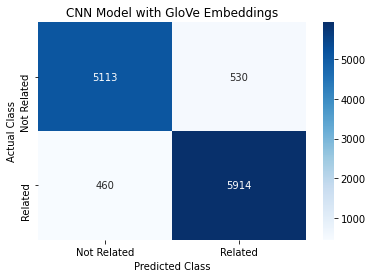

In [ ]:
get_confusion_matrix(glove_models['cnn'], x_test_pad)

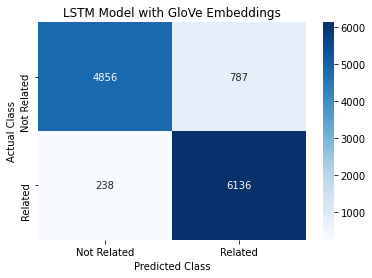

In [ ]:
get_confusion_matrix(glove_models['lstm'], x_test_pad)

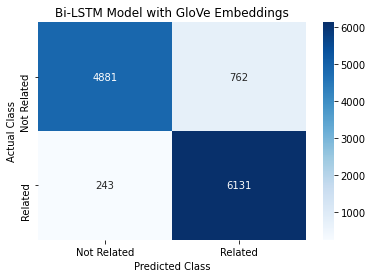

In [ ]:
get_confusion_matrix(glove_models['bilstm'], x_test_pad)

In [ ]:
y_predict = glove_models['lstm'].predict(x_test_pad)
y_predict_final = np.argmax(y_predict, axis=1)
y_predict

array([[0.96530515, 0.03469479],
       [0.20105883, 0.79894114],
       [0.42987606, 0.5701239 ],
       ...,
       [0.0648812 , 0.93511873],
       [0.99324155, 0.00675846],
       [0.16949822, 0.8305018 ]], dtype=float32)

In [ ]:
mismatch = []
for i in range(len(y_predict_final)):
    if y_predict_final[i]!=test_data['label'][i]:
        mismatch.append(i)

In [ ]:
index = 4305
print(test_data['tweet'][index])
print('\n Actual Class of Tweet {}:'.format(test_data['label'][index]))
print('\n Predicted Class of Tweet {}:'.format(y_predict_final[index]))

Pray for Waco. Pray for our nation. http://t.co/6krMC4YlaB

 Actual Class of Tweet 1:

 Predicted Class of Tweet 0:


In [ ]:
index = 4425
print(test_data['tweet'][index])
print('\n Actual Class of Tweet {}:'.format(test_data['label'][index]))
print('\n Predicted Class of Tweet {}:'.format(y_predict_final[index]))

RT @adhigoen: RT @HotelChatter Folks On Twitter Remind Us That Hurricane Hotel Stays Can Be Fun Too http://t.co/Uvw5cZXa #hotels #travel

 Actual Class of Tweet 0:

 Predicted Class of Tweet 1:


In [ ]:
index = 4191
print(test_data['tweet'][index])
print('\n Actual Class of Tweet {}:'.format(test_data['label'][index]))
print('\n Predicted Class of Tweet {}:'.format(y_predict_final[index]))

Sandy, you put it down like New York City...  I never sleep!

 Actual Class of Tweet 0:

 Predicted Class of Tweet 1:


In [ ]:
index = 4325
print(test_data['tweet'][index])
print('\n Actual Class of Tweet {}:'.format(test_data['label'][index]))
print('\n Predicted Class of Tweet {}:'.format(y_predict_final[index]))

The only thing that stays the same, is everything changes. #timemarcheson

 Actual Class of Tweet 0:

 Predicted Class of Tweet 1:
